# Contextual Retrieval for Multimodal RAG with Azure AI Search and Azure OpenAI in LlamaIndex

## Introduction

In this notebook, we'll demonstrate how to build a contextual retrieval multimodal Retrieval-Augmented Generation (RAG) pipeline using Azure AI Search and Azure OpenAI in LlamaIndex.

We'll walk through the following steps:

1. **Setup:** Install necessary packages and set up credentials.
2. **Load and Parse Document:** Download and parse a PDF document into text and images.
3. **Create Text Nodes with Contextual Metadata:** Generate contextual summaries for each text chunk.
4. **Map Metadata to Azure AI Search Schema:** Define how metadata fields correspond to Azure AI Search fields.
5. **Initialize Azure AI Search Vector Store:** Set up the vector store with the appropriate schema.
6. **Index Documents into Azure AI Search:** Index the text nodes with metadata into Azure AI Search.
7. **Build Multimodal Query Engine:** Create a query engine that can handle text and images.
8. **Perform Queries:** Execute queries and observe how contextual retrieval improves the results.

This notebook is designed for beginners and provides detailed explanations and comments throughout.

## Prerequisites
1. An Azure account with access to Azure AI Search and Azure OpenAI services.
2. API keys and endpoints for both services.
3. Python environment with necessary packages installed.

## 1.Setup
### 1.1 Install Required Packages
First, we need to install the required Python packages. Run the following commands in your terminal or uncomment and run them in your notebook if necessary.

In [ ]:
# Install necessary packages
# !pip install llama-index
# !pip install wget
# !pip install llama-index-vector-stores-azureaisearch
# !pip install azure-search-documents 
# !pip install llama-index-embeddings-azure-openai
# !pip install llama-index-llms-azure-openai
# !pip install llama-index-multi-modal-llms-azure-openai
# !pip install openai
# !pip install nest_asyncio

In [100]:
# Display the version of each installed package
!pip show llama-index | findstr Version
!pip show wget | findstr Version
!pip show llama-index-vector-stores-azureaisearch | findstr Version
!pip show azure-search-documents | findstr Version
!pip show llama-index-embeddings-azure-openai | findstr Version
!pip show llama-index-llms-azure-openai | findstr Version
!pip show llama-index-multi-modal-llms-azure-openai | findstr Version
!pip show openai | findstr Version
!pip show nest_asyncio | findstr Version

Version: 0.11.17
Version: 3.2
Version: 0.2.2
Version: 11.5.1
Version: 0.2.5
Version: 0.2.1
Version: 0.2.0
Version: 1.45.0
Version: 1.6.0


### 1.2 Import Libraries
Now, let's import the necessary libraries.

In [82]:
# Initial Setup: Load environment variables and initialize services
import os
import json
import time
import logging
from copy import deepcopy
from dotenv import load_dotenv
import nest_asyncio
from typing import Optional

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient

from llama_index.core import StorageContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.schema import TextNode, ImageNode, NodeWithScore, MetadataMode
from llama_index.core.settings import Settings
from llama_index.core.query_engine import CustomQueryEngine, SimpleMultiModalQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement, MetadataIndexFieldType
from llama_index.multi_modal_llms.azure_openai

# Apply nest_asyncio to avoid asyncio errors in notebooks
nest_asyncio.apply()

### 1.3 Set Up Azure Credentials
Replace the placeholders with your Azure OpenAI and Azure AI Search credentials.

In [29]:
# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME")
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
INDEX_NAME = "llamaindex-multimodal-contextual-retreival"

### 1.4 Initialize LLM and Embedding Models and Azure AI Search client


In [31]:
# Initialize Azure OpenAI models
llm = AzureOpenAI(
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-06-01"
)

embed_model = AzureOpenAIEmbedding(
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-06-01"
)

Settings.llm = llm
Settings.embed_model = embed_model

# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)


### 1.5 Setup Observability with Arize Phoenix 

In [231]:
# setup Arize Phoenix for logging/observability
import llama_index.core
import os

PHOENIX_API_KEY = os.getenv("PHOENIX_API_KEY")
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={PHOENIX_API_KEY}"
llama_index.core.set_global_handler(
    "arize_phoenix", endpoint="https://llamatrace.com/v1/traces"
)

# os.environ["PHOENIX_CLIENT_HEADERS"] = f"api_key={PHOENIX_API_KEY}"
# os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "https://app.phoenix.arize.com"

# import phoenix as px

# px_client = px.Client()


Attempting to instrument while already instrumented


## 2. Load and Parse the Document
### 2.1 Download the ICONIQ AI Report
We'll use the State of AI Report October 2024
[STATE OF THE AI OCTOBER 2024 REPORT](https://docs.google.com/presentation/d/1GmZmoWOa2O92BPrncRcTKa15xvQGhq7g4I4hJSNlC0M/edit).

In [ ]:
# Create directories to store data
os.makedirs('data', exist_ok=True)
os.makedirs('data_images_iconiq', exist_ok=True)

# Download the PPT report
!wget "https://docs.google.com/presentation/d/1GmZmoWOa2O92BPrncRcTKa15xvQGhq7g4I4hJSNlC0M/edit" -O data/state-of-ai.pptx


### 2.2 Parse the Document Using LlamaParse
We'll parse the PDF into text and images using `LlamaParse`. Note that using `LlamaParse` with premium mode may incur costs.

In [ ]:
from llama_parse import LlamaParse

# Initialize LlamaParse
parser = LlamaParse(
    result_type="markdown",
    premium_mode=True
)

# Parse the PDF document
print(f"Parsing text...")
md_json_objs = parser.get_json_result("data/pptx/State of AI Report - 2024 ONLINE.pptx")
md_json_list = md_json_objs[0]["pages"]

# Optionally, extract images
image_dicts = parser.get_images(md_json_objs, download_path="data_images_state_of_ai_report_2024")

In [33]:
print(md_json_list[10]["md"])

Introduction | **Research** | Industry | Politics | Safety | #stateofai |
Predictions

# Section 1: Research

stateof.ai


## 3. Build Multimodal Index
We will build a multimodal index over the parsed document by creating text nodes that contain metadata referencing the original image paths.

### 3.1 Get Text Nodes
We'll create TextNode objects from the parsed markdown data, attaching metadata such as page numbers and image paths.

In [97]:
import re
from copy import deepcopy
from pathlib import Path

def get_page_number(file_name):
    match = re.search(r"-page_(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0

def _get_sorted_image_files(image_dir):
    """Get image files sorted by page."""
    raw_files = [
        f for f in list(Path(image_dir).iterdir()) if f.is_file() and "-page" in str(f)
    ]
    sorted_files = sorted(raw_files, key=get_page_number)
    return sorted_files

# Attach image metadata to the text nodes
def get_text_nodes(image_dir, json_dicts):
    """Create TextNodes with metadata including image paths and doc_id."""
    nodes = []

    image_files = _get_sorted_image_files(image_dir)
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        # Assign a unique doc_id for each text node
        doc_id = f"doc_{idx+1}"  # Can be a string or an integer

        # Add doc_id to the metadata
        chunk_metadata = {
            "page_num": idx + 1,
            "image_path": str(image_files[idx]),
            "parsed_text_markdown": md_texts[idx],
        }

        node = TextNode(
            text="",
            metadata=chunk_metadata,
        )
        nodes.append(node)

    return nodes


# Create text nodes
text_nodes = get_text_nodes(image_dir="data_images_state_of_ai_report_2024", json_dicts=md_json_list)

# Print an example node
print(text_nodes[0].get_content(metadata_mode="all"))


page_num: 1
image_path: data_images_state_of_ai_report_2024\58f8dea9-e908-4db0-82dc-f1747fc8abb3-page_1.jpg
parsed_text_markdown: # STATE OF AI REPORT

October 10, 2024

Nathan Benaich

## AIR STREET CAPITAL

stateof                              airstreet.


### 3.2 Add Contextual Summaries
We implement the key step in contextual retrieval by attaching metadata to each chunk that situates it within the overall document context.

In [173]:
from llama_index.core.schema import MetadataMode
from copy import deepcopy
from llama_index.core.llms import ChatMessage
from llama_index.core.prompts import ChatPromptTemplate
import time

# Prepare prompts for contextual summaries
whole_doc_text = """\
Here is the entire document.
<document>
{WHOLE_DOCUMENT}
</document>"""

chunk_text = """\
Here is the chunk we want to situate within the whole document
<chunk>
{CHUNK_CONTENT}
</chunk>
Please give a short succinct context to situate this chunk within the overall document for \
the purposes of improving search retrieval of the chunk. Answer only with the succinct context and nothing else."""

# Modify the function that creates contextual nodes so that they are well incorporated in embedding
def create_contextual_nodes(nodes, llm):
    """Function to create contextual nodes with added context."""
    nodes_modified = []

    # Get overall document text
    doc_text = "\n".join([n.get_content(metadata_mode=MetadataMode.LLM) for n in nodes])

    for idx, node in enumerate(nodes):
        start_time = time.time()
        new_node = deepcopy(node)

        # Messages to generate contextual summary
        messages = [
            ChatMessage(role="system", content="You are a helpful AI Assistant."),
            ChatMessage(
                role="user",
                content=[
                    {
                        "text": whole_doc_text.format(WHOLE_DOCUMENT=doc_text),
                        "type": "text",
                        "cache_control": {"type": "ephemeral"},
                    },
                    {
                        "text": chunk_text.format(
                            CHUNK_CONTENT=node.get_content(metadata_mode=MetadataMode.LLM)
                        ),
                        "type": "text",
                    },
                ],
            ),
        ]

        # Generate contextual summary
        new_response = llm.chat(messages)
        new_node.metadata["context"] = str(new_response)

        nodes_modified.append(new_node)
        print(f"Completed node {idx}, {time.time() - start_time}")

    return nodes_modified

# Create contextual text nodes with context incorporated
new_text_nodes = create_contextual_nodes(text_nodes, llm)

# Print to verify that context is included in metadata
print(new_text_nodes[0].metadata)

# Step 2: Use LlamaIndex Documents with Context in Embedding
from llama_index.core import Document

llama_documents = []

# Create LlamaIndex Documents by including context in the embedding text
for node in new_text_nodes:
    document = Document(
        text=node.get_content(metadata_mode=MetadataMode.EMBED),  # Use the metadata that includes context for embeddings
        metadata=node.metadata,
        excluded_llm_metadata_keys=[""],
        excluded_embed_metadata_keys=["page_num", "image_path"],
    )
    llama_documents.append(document)

# Observing what LLM and Embedding model receive
print(
    "\nThe LLM sees this: \n",
    llama_documents[0].get_content(metadata_mode=MetadataMode.LLM),
)
print(
    "\nThe Embedding model sees this: \n",
    llama_documents[0].get_content(metadata_mode=MetadataMode.EMBED),
)


Completed node 0, 5.321974277496338
Completed node 1, 1.5373625755310059
Completed node 2, 7.4741692543029785
Completed node 3, 7.676878929138184
Completed node 4, 5.8342506885528564
Completed node 5, 4.514301538467407
Completed node 6, 4.400418996810913
Completed node 7, 4.609893321990967
Completed node 8, 7.135084390640259
Completed node 9, 4.469281911849976
Completed node 10, 8.35994577407837
Completed node 11, 4.56611967086792
Completed node 12, 4.309324502944946
Completed node 13, 8.147826433181763
Completed node 14, 8.313083410263062
Completed node 15, 7.997103691101074
Completed node 16, 1.671701431274414
Completed node 17, 7.518136739730835
Completed node 18, 8.133944272994995
Completed node 19, 4.358154296875
Completed node 20, 4.468562841415405
Completed node 21, 7.7935590744018555
Completed node 22, 7.356404542922974
Completed node 23, 9.392450094223022
Completed node 24, 4.520427465438843
Completed node 25, 1.340127944946289
Completed node 26, 7.680083751678467
Completed no

In [175]:
new_text_nodes[0].metadata["context"]

'assistant: This chunk serves as the title page of the "State of AI Report 2024," authored by Nathan Benaich and published by Air Street Capital. It introduces the report, which compiles insights and analyses on the advancements and implications of artificial intelligence over the past year.'

## 4. Build Index with Azure AI Search
We will now build the index using Azure AI Search.

### 4.1 Initialize Azure AI Search Vector Store

In [ ]:
# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
    "context": ("context", MetadataIndexFieldType.STRING),  # Only used for contextual index
}

# --- Contextual Retrieval Index ---

# Create the Azure AI Search vector store for contextual retrieval
contextual_vector_store = AzureAISearchVectorStore(
    search_or_index_client=index_client,
    index_name="llamaindex-multimodal-contextual-retrieval",
    index_management=IndexManagement.CREATE_IF_NOT_EXISTS,
    id_field_key="id",
    chunk_field_key="parsed_text_markdown",  
    embedding_field_key="embedding",
    embedding_dimensionality=1536,  # Based on embedding model
    metadata_string_field_key="metadata",
    doc_id_field_key="doc_id",
    filterable_metadata_field_keys=metadata_fields,
    language_analyzer="en.lucene",
    vector_algorithm_type="exhaustiveKnn",
)

## 4.2 Index the Nodes
We will index the contextual text nodes into Azure AI Search.

In [ ]:
# Create storage context for contextual retrieval
contextual_storage_context = StorageContext.from_defaults(vector_store=contextual_vector_store)

# Build the contextual retrieval index using new_text_nodes
contextual_index = VectorStoreIndex(
    nodes=new_text_nodes,
    storage_context=contextual_storage_context,
    embed_model=embed_model,
    llm=llm,
    show_progress=True,
)

## 5. Build Baseline Index
We will also build a baseline index with the text nodes without contextual summaries for comparison.

In [ ]:
# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
}

# --- Baseline Index ---

# Create the Azure AI Search vector store for baseline retrieval
baseline_vector_store = AzureAISearchVectorStore(
    search_or_index_client=index_client,
    index_name="llamaindex-multimodal-baseline",
    index_management=IndexManagement.CREATE_IF_NOT_EXISTS,
    id_field_key="id",
    chunk_field_key="parsed_text_markdown",
    embedding_field_key="embedding",
    embedding_dimensionality=1536,
    metadata_string_field_key="metadata",
    doc_id_field_key="doc_id",
    filterable_metadata_field_keys=metadata_fields,
    language_analyzer="en.lucene",
    vector_algorithm_type="exhaustiveKnn",
)

# Create storage context for baseline retrieval
baseline_storage_context = StorageContext.from_defaults(vector_store=baseline_vector_store)

# Build the baseline index using original text_nodes (without contextual metadata)
baseline_index = VectorStoreIndex(
    nodes=text_nodes,
    storage_context=baseline_storage_context,
    embed_model=embed_model,
    llm=llm,
    show_progress=True,
)

## 6. Build Multimodal Query Engine
We will build a custom multimodal query engine that can retrieve both text and image data.

In [206]:
from llama_index.core.query_engine import CustomQueryEngine, BaseQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal
from llama_index.core.schema import ImageNode, NodeWithScore, MetadataMode
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from typing import Optional

# Initialize AzureOpenAIMultiModal for GPT-4V
azure_openai_mm_llm = AzureOpenAIMultiModal(
    engine="gpt-4o-mini",  # Use GPT-4V (vision model)
    api_version="2024-06-01",
    model="gpt-4o-mini",
    max_new_tokens=4096,
    api_key=AZURE_OPENAI_API_KEY,
    api_base=AZURE_OPENAI_ENDPOINT,
)

QA_PROMPT_TMPL = """\
Below we give parsed text from slides in parsed markdown format, as well as the image.

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the parsed markdown or raw text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)


class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine.

    Takes in a retriever to retrieve a set of document nodes.
    Also takes in a prompt template and multimodal model.

    """

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: AzureOpenAIMultiModal

    def __init__(self, qa_prompt: Optional[PromptTemplate] = None, **kwargs) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str):
        # retrieve text nodes
        nodes = self.retriever.retrieve(query_str)
        # create ImageNode items from text nodes
        image_nodes = [
            NodeWithScore(node=ImageNode(image_path=n.metadata["image_path"]))
            for n in nodes
        ]

        # create context string from text nodes, dump into the prompt
        context_str = "\n\n".join(
            [r.get_content(metadata_mode=MetadataMode.LLM) for r in nodes]
        )
        fmt_prompt = self.qa_prompt.format(context_str=context_str, query_str=query_str)

        # synthesize an answer from formatted text and images
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[image_node.node for image_node in image_nodes],
        )
        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={"text_nodes": nodes, "image_nodes": image_nodes},
        )

        return response

In [214]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.vector_stores.types import VectorStoreQueryMode
from llama_index.core import get_response_synthesizer
import pprint

# define response synthesizer
response_synthesizer = get_response_synthesizer()

contextual_query_engine = MultimodalQueryEngine(
    retriever=contextual_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.SEMANTIC_HYBRID, similarity_top_k=3),
    multi_modal_llm=azure_openai_mm_llm,
)
baseline_query_engine = MultimodalQueryEngine(
    retriever=baseline_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.SEMANTIC_HYBRID, similarity_top_k=3),
    multi_modal_llm=azure_openai_mm_llm,
)

## 7. Try Out Queries
Let's test our multimodal RAG pipeline by asking some questions.
### 7.1 Query Example 1

Query: What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?
Retrieved Images:



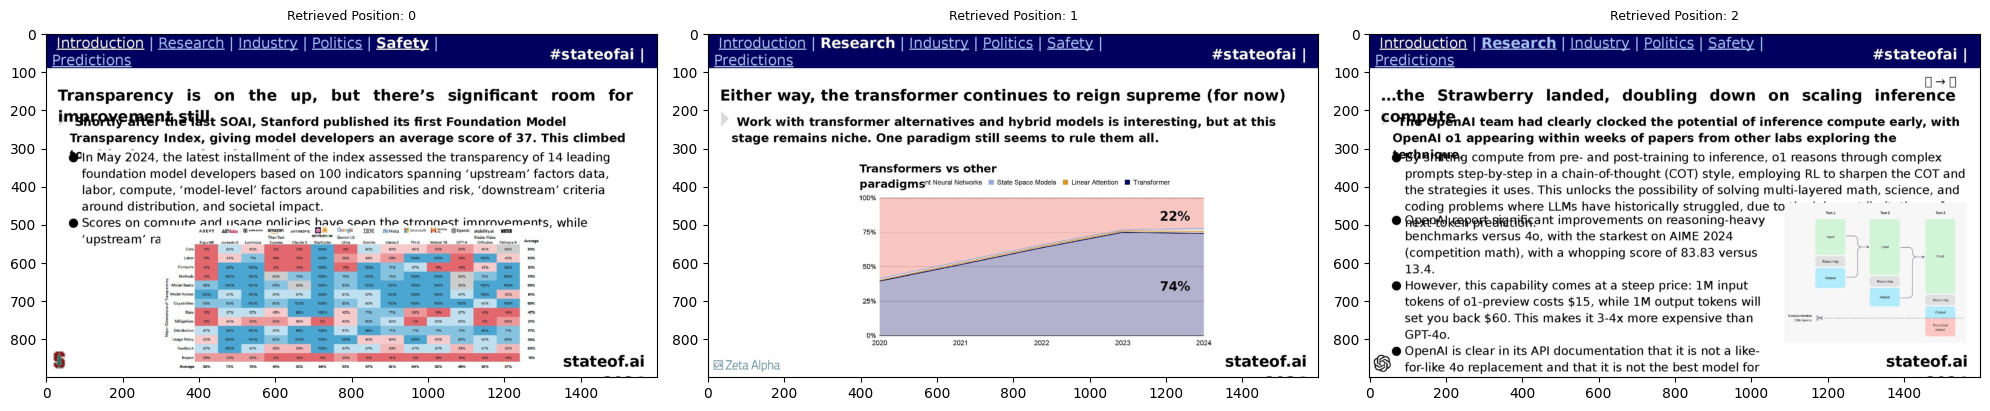

Response: The trends in AI compute efficiency identified in 2024 highlight a significant shift towards inference compute, particularly with OpenAI's o1 model. This model emphasizes reasoning through complex prompts in a chain-of-thought style, which has led to substantial improvements in performance on reasoning-heavy benchmarks. For instance, OpenAI reported a score of 83.83 on the AIME 2024 competition math benchmark, compared to just 13.4 for its previous model, GPT-4o.

In terms of cost, the inference compute capabilities of o1 are notably more expensive, with 1 million input tokens costing $15 and 1 million output tokens costing $60, making it 3-4 times more expensive than GPT-4o.

This information was derived from the parsed markdown, specifically from the section discussing OpenAI's advancements in inference compute. There were no discrepancies between the parsed markdown and the raw text regarding this topic, as both sources consistently highlighted the same trends and performa

In [215]:
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode
from openinference.instrumentation import using_metadata


# Query with baseline retrieval
query = "What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?"
baseline_response = baseline_query_engine.query(query)

with using_metadata({"engine": "baseline_query_engine"}):
    result_b = baseline_query_engine.query(query)
    display_query_and_multimodal_response(query, result_b, 8, 20)
    print("\nSource Nodes for baseline_query_engine:")
    for node in result_b.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

### 7.2 Query Example 2

Query: What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?
Retrieved Images:



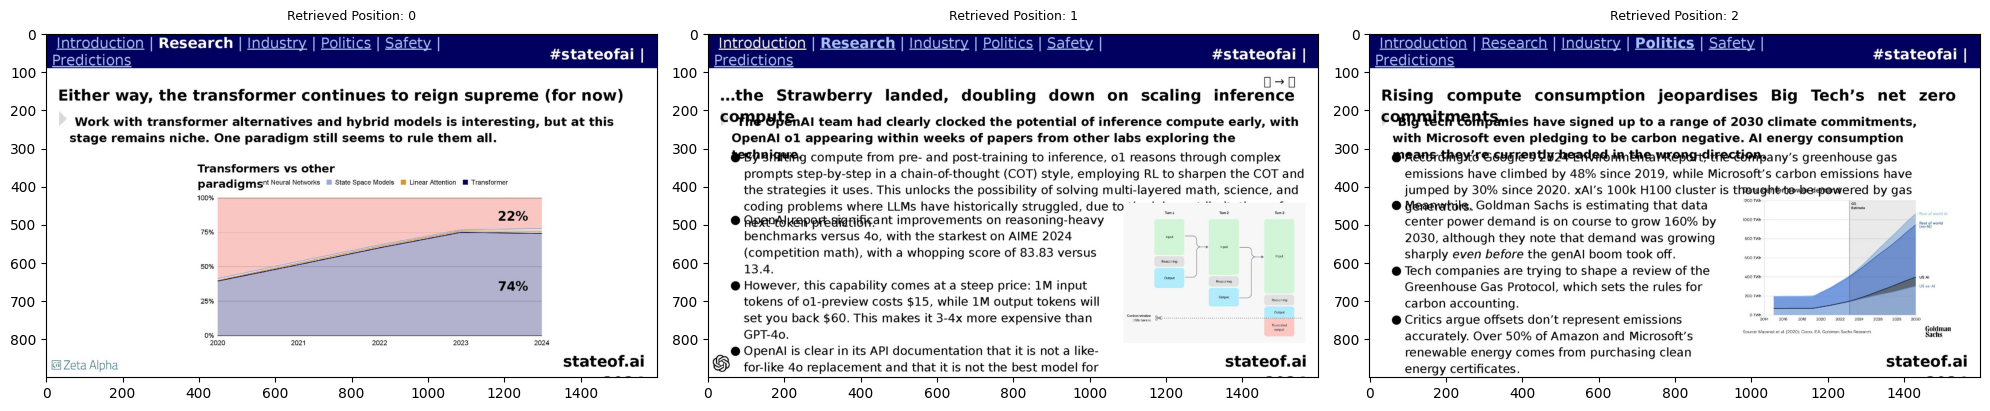

Response: The trends in AI compute efficiency identified in 2024 highlight a significant shift towards inference compute, particularly with OpenAI's o1 model. This model demonstrates improved reasoning capabilities compared to previous models, achieving notable scores on reasoning-heavy benchmarks. However, this advancement comes at a high cost, making it 3-4 times more expensive than earlier models like GPT-4o.

From the parsed markdown, we see that the focus is on the dominance of transformer models and the implications of rising compute consumption on Big Tech's climate commitments. The performance of inference compute is emphasized through OpenAI's advancements, showcasing its potential to solve complex problems more effectively than previous models.

There are no discrepancies between the parsed markdown and the context provided; the answer is derived directly from the parsed text. The reasoning for the final answer is based on the clear presentation of trends in AI compute effici

In [216]:
from llama_index.core.response.notebook_utils import display_query_and_multimodal_response
from llama_index.core.schema import MetadataMode
import os

# Query with contextual retrieval
query = "What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?"
contextual_response = contextual_query_engine.query(query)
with using_metadata({"engine": "contextual_query_engine"}):
    result_a = contextual_query_engine.query(query)
    display_query_and_multimodal_response(query, result_a, 8, 20)
    print("\nSource Nodes for query_engine:")
    for node in result_a.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

In [217]:
def get_source_page_nums(response):
    page_nums = [str(node.node.metadata.get("page_num", "N/A")) for node in response.source_nodes]
    print(",".join(page_nums))

# Compare source page numbers
print("Pages retrieved with contextual retrieval:")
get_source_page_nums(contextual_response)

print("Pages retrieved without contextual retrieval:")
get_source_page_nums(baseline_response)


Pages retrieved with contextual retrieval:
28,13,167
Pages retrieved without contextual retrieval:
195,28,13


### 7.3 Query Example 3

Query: What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?
Retrieved Images:



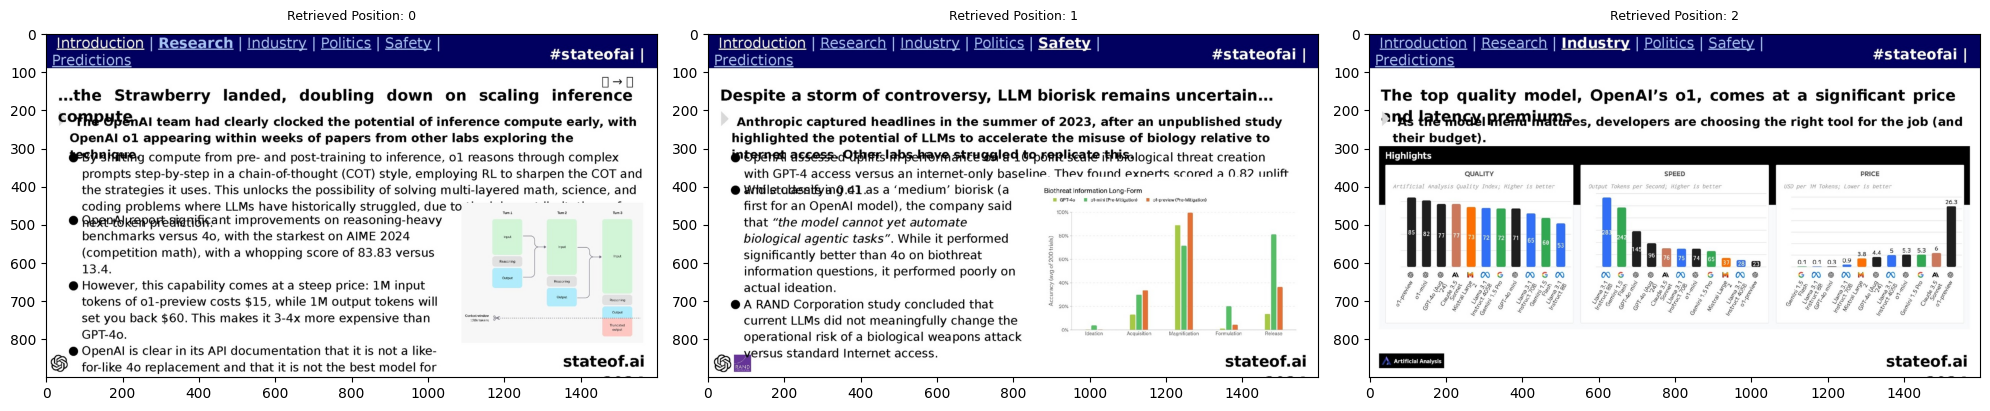

Response: The current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems are as follows:

### Capabilities:
1. **Inference Compute**: The o1 model shifts compute from pre- and post-training to inference, allowing it to reason through complex prompts step-by-step in a chain-of-thought (COT) style.
2. **Improved Performance**: It has shown significant improvements on reasoning-heavy benchmarks compared to its predecessor, GPT-4o, particularly on the AIME 2024 competition math benchmark, achieving a score of 83.83 compared to 13.4 for GPT-4o.
3. **Handling Complex Problems**: The model can tackle multi-layered math, science, and coding problems, which have historically been challenging for LLMs due to limitations in next-token prediction.

### Limitations:
1. **Cost**: The o1 model is expensive to use, with 1M input tokens costing $15 and 1M output tokens costing $60, making it 3-4 times more expensive than GPT-4o.
2. **Not a Direct Replacement**: O

In [218]:
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode

# Query with baseline retrieval
query = "What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?"
baseline_response = baseline_query_engine.query(query)

with using_metadata({"engine": "baseline_query_engine"}):
    result_b = baseline_query_engine.query(query)
    display_query_and_multimodal_response(query, result_b, 8, 20)
    print("\nSource Nodes for baseline_query_engine:")
    for node in result_b.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

### Query Example 4

Query: What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?
Retrieved Images:



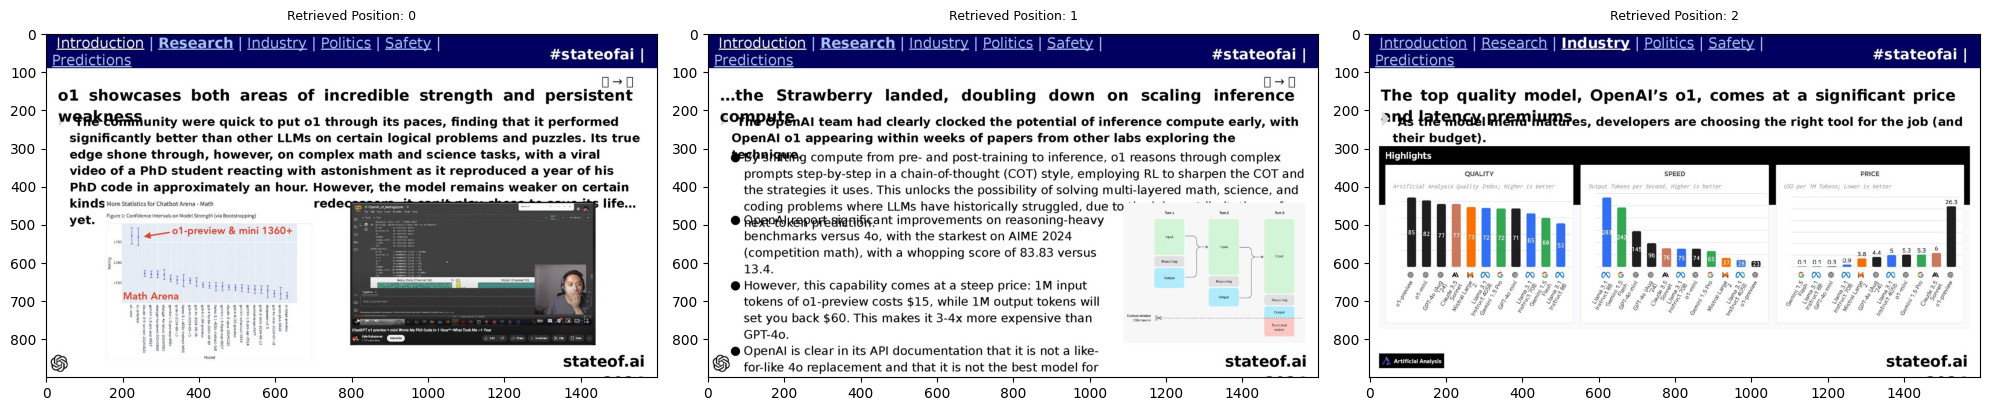

Response: The current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems are as follows:

### Capabilities:
1. **Strength in Complex Tasks**: The o1 model performs significantly better than other large language models (LLMs) on logical problems and complex math and science tasks.
2. **Chain-of-Thought Reasoning**: It employs a chain-of-thought (COT) style of reasoning, which allows it to tackle multi-layered math, science, and coding problems effectively.
3. **High Benchmark Scores**: The model has shown significant improvements on reasoning-heavy benchmarks, achieving a score of 83.83 on AIME 2024 (competition math), compared to 13.4 for its predecessor.

### Limitations:
1. **Weakness in Spatial Reasoning**: The model struggles with certain types of spatial reasoning tasks.
2. **Cost**: The operational cost is high, with 1 million input tokens costing $15 and 1 million output tokens costing $60, making it 3-4 times more expensive than previous 

In [204]:
from llama_index.core.response.notebook_utils import display_query_and_multimodal_response
from llama_index.core.schema import MetadataMode
from openinference.instrumentation import using_metadata
import os

# Query with contextual retrieval
query = "What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?"
contextual_response = contextual_query_engine.query(query)
with using_metadata({"engine": "contextual_query_engine"}):
    result_a = contextual_query_engine.query(query)
    display_query_and_multimodal_response(query, result_a, 8, 20)
    print("\nSource Nodes for query_engine:")
    for node in result_a.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

In [219]:
def get_source_page_nums(response):
    page_nums = [str(node.node.metadata.get("page_num", "N/A")) for node in response.source_nodes]
    print(",".join(page_nums))

# Compare source page numbers
print("Pages retrieved with contextual retrieval:")
get_source_page_nums(contextual_response)

print("Pages retrieved without contextual retrieval:")
get_source_page_nums(baseline_response)


Pages retrieved with contextual retrieval:
28,13,167
Pages retrieved without contextual retrieval:
13,201,108


## 8. Evaluations with Arize Phoenix
### 8.1 Run Your Query Engine and View Your Traces in Phoenix

In [234]:
from tqdm import tqdm
import json
from openinference.instrumentation import using_metadata
from phoenix.trace import using_project

# Load all evaluation questions from queries.jsonl
eval_questions = []
with open("eval/contextual-queries.jsonl", "r") as file:
    for line in file:
        # Parse each line as JSON and extract the query
        json_line = json.loads(line.strip())
        eval_questions.append(json_line)

# List of query engines and their respective project names
query_engines = [
    (baseline_query_engine, "Baseline"),
    (contextual_query_engine, "Contextual"),
]

# Loop through each question and query it against each engine
for query_data in tqdm(eval_questions):
    query = query_data["query"]
    query_classification = query_data.get(
        "query_classification", "undefined"
    )  # Default to 'undefined' if not present

    for engine, project_name in query_engines:
        try:
            metadata = query_classification
            with using_project(project_name), using_metadata(metadata):
                # Assuming the query method expects a string query and returns results
                engine.query(query)
        except Exception as e:
            print(f"Error querying {project_name} for query '{query}': {e}")

  0%|          | 0/6 [00:00<?, ?it/s]Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Dev\azure-ai-search-python-playground\.venv\Lib\site-packages\urllib3\connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "c:\Dev\azure-ai-search-python-playground\.venv\Lib\site-packages\urllib3\connectionpool.py", line 536, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "c:\Dev\azure-ai-search-python-playground\.venv\Lib\site-packages\urllib3\connection.py", line 507, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\fsunavala\AppData\Local\Programs\Python\Python311\Lib\http\client.py", line 1395, in getresponse
    response.begin()
  File "C:\Users\fsunavala\AppData\Local\Programs\Python\Python311\Lib\http\client.py", line 325, in begin
    version, status, reason = self._read_status()
    

### 8.2 Export and Evaluate Your Trace Data

In [251]:
import phoenix as px
import os

# Ensure the PHOENIX_API_KEY environment variable is set
PHOENIX_API_KEY = os.getenv("PHOENIX_API_KEY")

# Initialize the Phoenix client with the correct endpoint and headers
px_client = px.Client(endpoint="https://llamatrace.com/v1/traces", headers={"Authorization": f"Bearer {PHOENIX_API_KEY}"})

# Retrieve spans dataframe for the specified project
phoenix_df = px_client.get_spans_dataframe(project_name="baseline")

# Display the dataframe
print(phoenix_df.head())

Arize Phoenix is not running on https://llamatrace.com/v1/traces/. Launch Phoenix with `import phoenix as px; px.launch_app()`


HTTPStatusError: Redirect response '302 Found' for url 'https://llamatrace.com/v1/traces/v1/spans?project_name=baseline&project-name=baseline'
Redirect location: '/login'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/302

In [250]:
from phoenix.evals import (
    HallucinationEvaluator,
    OpenAIModel,
    QAEvaluator,
    RelevanceEvaluator,
    run_evals,
)
from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from phoenix.trace import DocumentEvaluations, SpanEvaluations
from tqdm import tqdm

# Define the evaluation model
eval_model = OpenAIModel(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_deployment="gpt-4o",  # I'm using gpt-4o for evaluation
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    api_version="2024-06-01"
)

# Define evaluators
hallucination_evaluator = HallucinationEvaluator(eval_model)
qa_correctness_evaluator = QAEvaluator(eval_model)
relevance_evaluator = RelevanceEvaluator(eval_model)

# List of project names
projects = ["Baseline", "Contextual"]

# Create DataFrames for queries and retrieved documents for each project
queries_dfs = {}
retrieved_documents_dfs = {}

for project in projects:
    queries_dfs[project] = get_qa_with_reference(px_client, project_name=project)
    retrieved_documents_dfs[project] = get_retrieved_documents(px_client, project_name=project)

# Loop through each project and perform evaluations
for project in projects:
    queries_df = queries_dfs[project]
    retrieved_documents_df = retrieved_documents_dfs[project]
    
    # Run evaluations
    hallucination_eval_df, qa_correctness_eval_df = run_evals(
        dataframe=queries_df,
        evaluators=[hallucination_evaluator, qa_correctness_evaluator],
        provide_explanation=True,
    )
    relevance_eval_df = run_evals(
        dataframe=retrieved_documents_df,
        evaluators=[relevance_evaluator],
        provide_explanation=True,
    )[0]
    
    # Log evaluations
    px.Client().log_evaluations(
        SpanEvaluations(eval_name=f"Hallucination_{project}", dataframe=hallucination_eval_df),
        SpanEvaluations(eval_name=f"QA Correctness_{project}", dataframe=qa_correctness_eval_df),
        DocumentEvaluations(eval_name=f"Relevance_{project}", dataframe=relevance_eval_df),
    )

HTTPStatusError: Redirect response '302 Found' for url 'https://llamatrace.com/v1/spans?project_name=Baseline&project-name=Baseline'
Redirect location: '/login'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/302